In [5]:
# 导入必要的库
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from joblib import dump, load

In [ ]:
# 挂载谷歌硬盘
from google.colab import drive
drive.mount('/content/drive')

# 加载数据集
file_path = '/content/drive/MyDrive/Colab Notebooks/Processed_Dataset_of_Diabetes_Version3.csv'
data = pd.read_csv(file_path)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 8 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

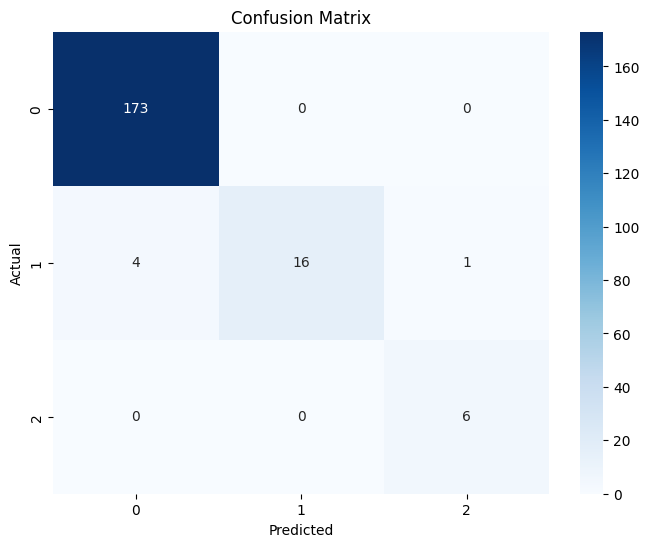

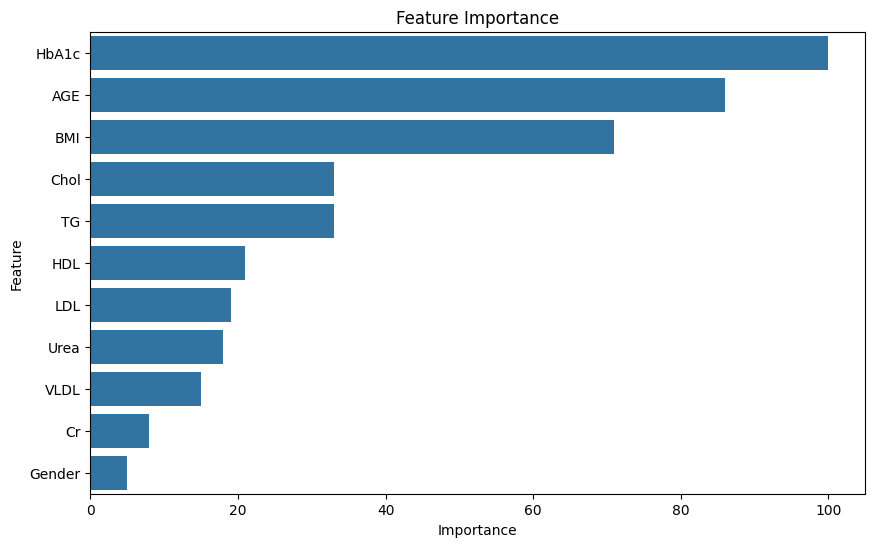

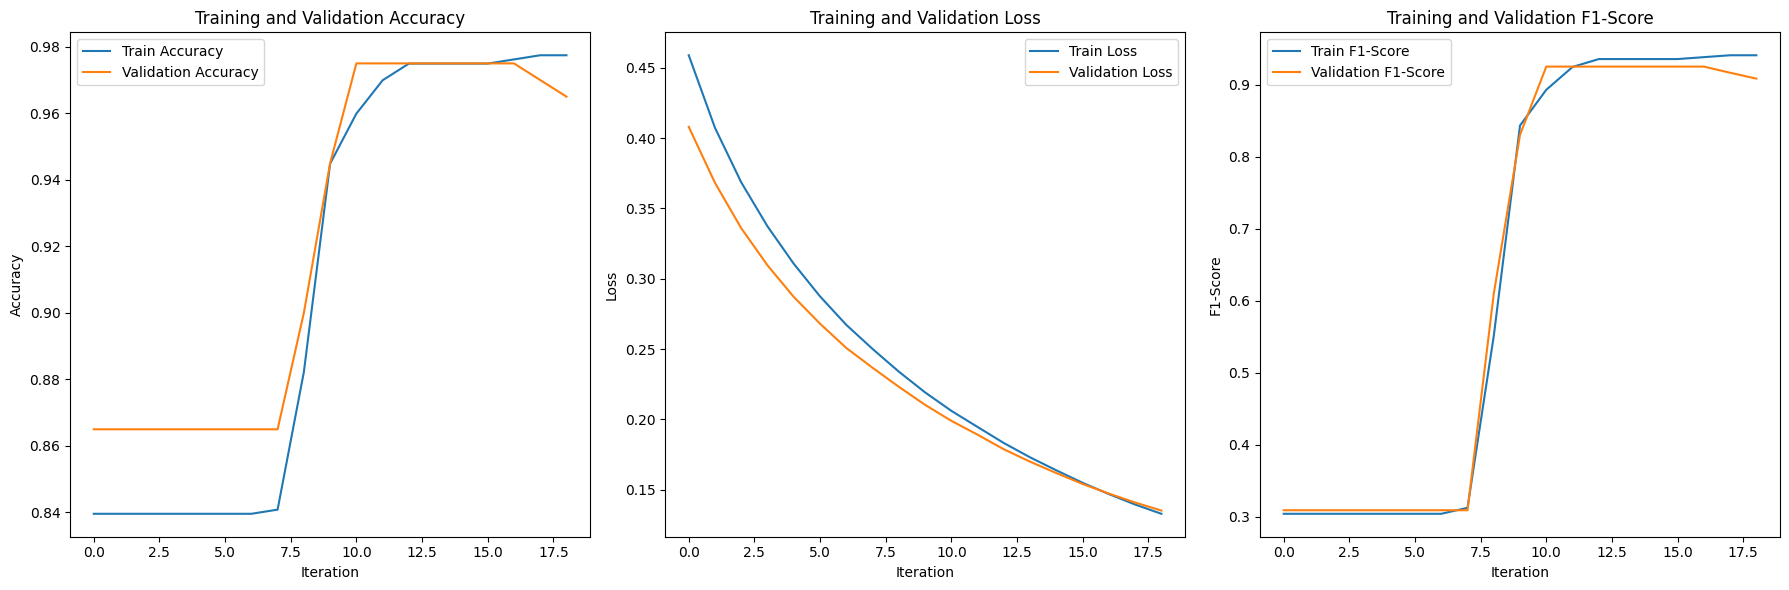

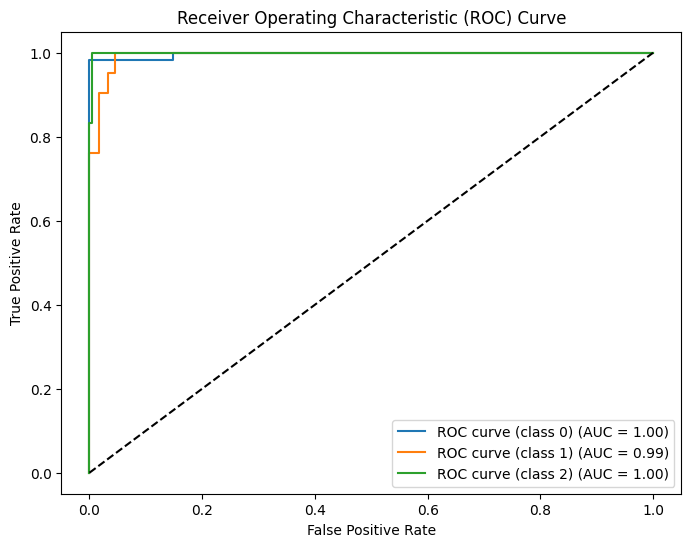

In [3]:

# 加载数据集
file_path = './Processed_Dataset_of_Diabetes_Version3.csv'
data = pd.read_csv(file_path)

# 特征和目标变量
X = data.drop(columns=['CLASS'])  # 特征
y = data['CLASS']                # 目标变量

# 数据标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建 LightGBM 数据集
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 参数设置（多分类任务）
params = {
    'objective': 'multiclass',         # 多分类任务
    'metric': 'multi_logloss',         # 评估指标为多分类对数损失
    'boosting_type': 'gbdt',           # 使用梯度提升决策树
    'num_class': 3,                    # 类别数
    'num_leaves': 15,                  # 叶子节点数
    'learning_rate': 0.05,             # 学习率
    'feature_fraction': 0.9,           # 特征采样比例
    'verbose': 0,                      # 日志级别
    'min_data_in_leaf': 20,            # 每个叶子节点的最小样本数
    'max_depth': 7,                    # 树的最大深度
}

# 定义自定义评估函数（准确率）
def custom_eval(preds, data):
    labels = data.get_label()
    preds = preds.argmax(axis=1)  # 将概率转换为类别
    acc = accuracy_score(labels, preds)
    return 'accuracy', acc, True

# 定义自定义评估函数（F1 分数）
def custom_f1(preds, data):
    labels = data.get_label()
    preds = preds.argmax(axis=1)  # 将概率转换为类别
    f1 = f1_score(labels, preds, average='macro')  # 使用macro平均
    return 'f1_score', f1, True

# 设置回调函数
eval_results = {}
callbacks = [
    lgb.record_evaluation(eval_results),  # 记录评估结果
    lgb.early_stopping(stopping_rounds=8),  # 早停机制
]

# 训练模型
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'valid'],
    feval=[custom_eval, custom_f1],  # 自定义评估函数
    num_boost_round=1000,           # 最大迭代次数
    callbacks=callbacks             # 传递回调函数
)

# 对测试集进行预测
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_label = y_pred.argmax(axis=1)  # 将概率转换为类别

# 计算准确率
accuracy = accuracy_score(y_test, y_pred_label)
print(f"Accuracy: {accuracy:.2f}")

# 打印分类报告
print(classification_report(y_test, y_pred_label, zero_division=0))

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 绘制特征重要性
feature_importance = model.feature_importance()
feature_names = data.columns[:-1]  # 去掉目标变量 'CLASS'

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()

# 提取训练和验证的指标
train_acc = eval_results['train']['accuracy']
valid_acc = eval_results['valid']['accuracy']
train_loss = eval_results['train']['multi_logloss']
valid_loss = eval_results['valid']['multi_logloss']
train_f1 = eval_results['train']['f1_score']
valid_f1 = eval_results['valid']['f1_score']

# 绘制训练和验证的准确率、损失和 F1 分数
plt.figure(figsize=(18, 6))

# 准确率曲线
plt.subplot(1, 3, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# 损失曲线
plt.subplot(1, 3, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# F1 分数曲线
plt.subplot(1, 3, 3)
plt.plot(train_f1, label='Train F1-Score')
plt.plot(valid_f1, label='Validation F1-Score')
plt.xlabel('Iteration')
plt.ylabel('F1-Score')
plt.title('Training and Validation F1-Score')
plt.legend()

plt.tight_layout()
plt.show()

# 绘制 AUC-ROC 曲线
y_pred_proba = model.predict(X_test, num_iteration=model.best_iteration)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):  # 3 个类别
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [ ]:
# 保存模型
model.save_model('/content/drive/MyDrive/Colab Notebooks/diabetes_prediction_model.txt')

In [6]:
# 保存模型
dump(model, 'LightGBM.joblib')

['LightGBM.joblib']